In [91]:
import pandas as pd
import numpy as np
# from pandas_ods_reader import read_ods
import csv
# import xlrd
import tensorflow as tf
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Model, Input
from tensorflow.python.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from tensorflow.python.keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D
from keras.models import load_model
from nltk import word_tokenize
from sklearn.metrics import confusion_matrix, classification_report
# from tensorflow.python.keras.layers import LSTM, Dense from tensorflow.python.keras.models import Sequential

max_len = 50
max_len_char = 10


# Preparing Train Data Set

We used CoNLL dataset to train our model

These words form our dictionary and any word outside of this would be treated as an unknown word.
We store the words, character,tags which will be globally used across our code. 
We are also storing word_tag dictionary along with each sentence as a document(under the assumption that each document contains a single sentence)

In [163]:
def parseDocuments(filename,words):
    # Read the file row wise and parse each documents into tokens
    documents = []
    rows = []
    words_doc = []
    word_tag_dict = dict()
    document_word_tags = []
    with open (filename, 'r') as f:
        lines = f.readlines()
    for line in lines:
        rows.append(line.split('\t'))
        
    for row in rows:
        if len(row) > 2:
            words_doc.append((row[1],row[2]))
            words.append(row[1])
            tags.append(row[2])
            word_tag_dict[row[1]] = row[2]
        else:
            if len(words_doc) > 0:
                documents.append(words_doc)
                document_word_tags.append(word_tag_dict)
                word_tag_dict = dict()
                words_doc = []
    
    documents.append(words_doc)
    #print(documents)
    return documents,document_word_tags

def convertTokens2Index(documents):
    # Convert each token to its corresponding word_index for efficient access to that token
    #X_word = [[word_embeddings[word_label[0]] for word_label in document if word_label[0] in word_embeddings ] for document in documents]
    X_word = [[word2idx[w[0]] for w in document] for document in documents]

    X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')

    X_char = []
    for document in documents:
        sent_seq = []
        for i in range(max_len):
            word_seq = []
            for j in range(max_len_char):
                try:
                    word_seq.append(char2idx.get(document[i][0][j]))
                except:
                    word_seq.append(char2idx.get("PAD"))
            sent_seq.append(word_seq)
        X_char.append(np.array(sent_seq))


    y = [[tag2idx[word_label[1]] for word_label in document] for document in documents]
    y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')
    
    return X_word, X_char, y

In [164]:
words = []
tags = []
# words_doc = []
train_documents = []
test_documents = []
# word_tag_dict = dict()
document_word_tags_train = []
document_word_tags_test = []
word2idx = []
tag2idx = []
idx2word = []
idx2tag = []

train_documents,document_word_tags_train = parseDocuments("train.txt",words)
#print(document_word_tags_train)
test_documents,document_word_tags_test = parseDocuments("test.txt",words)
print(document_word_tags_test)

words = list(set(words))
tags = list(set(tags))
        
# print("Words size:", len(words))
# print("Tags", tags)

# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}
# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

chars = set([w_i for w in words for w_i in w])

n_words = len(words)
n_chars = len(chars)
n_tags = len(tags)

char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0


X_word_tr, X_char_tr, y_tr = convertTokens2Index(train_documents)
X_word_te, X_char_te, y_te = convertTokens2Index(test_documents)

#print(len(X_word_tr),len(X_char_tr), len(y_tr))
print(len(X_word_te),len(X_char_te), len(y_te))



#print(n_words)

[{'On': 'O', 'April': 'B-Other', '14': 'O', ',': 'O', 'while': 'O', 'attending': 'O', 'a': 'O', 'play': 'O', 'at': 'O', 'the': 'O', 'Ford': 'B-Org', 'Theatre': 'I-Org', 'in': 'O', 'Washington': 'B-Loc', 'Lincoln': 'B-Peop', 'was': 'O', 'shot': 'O', 'head': 'O', 'by': 'O', 'actor': 'O', 'John': 'B-Peop', 'Wilkes': 'I-Peop', 'Booth': 'I-Peop', 'who': 'O', 'cried': 'O', 'out': 'O', '`': 'O', 'Sic': 'B-Other', 'Semper': 'I-Other', 'Tyranus': 'I-Other', "'": 'O', '(': 'O', 'Thus': 'O', 'Ever': 'O', 'to': 'O', 'Tyrants': 'B-Other', 'motto': 'O', 'of': 'O', 'Virginia': 'B-Loc', ')': 'O', '.': 'O'}, {'(': 'O', 'Text': 'O', ')': 'O', 'The': 'O', 'situation': 'O', 'remains': 'O', 'explosive': 'O', 'in': 'O', 'Namialo': 'B-Loc', 'assembly': 'O', 'area': 'O', ',': 'O', 'Nampula': 'B-Loc', 'Province': 'I-Loc', 'where': 'O', 'the': 'O', 'government': 'O', 'soldiers': 'O', 'with': 'O', 'former': 'O', 'Northern': 'B-Org', 'Improvement': 'I-Org', 'Brigade': 'I-Org', 'Brigada': 'B-Org', 'de': 'I-Org', '

289 289 289


# Embedding matrix 

We use pre-trained word embeddings for our words which will be later used in our model. These are stored in our Embedding Matrix


In [165]:
EMBEDDING_DIM = 50
embedding_matrix = np.zeros((len(word2idx.keys()) +1, EMBEDDING_DIM))

f = open('vecs.lc.over100freq.txt',encoding='utf8',errors='ignore')
for line in f:
    values = line.split(' ')
    word = values[0]
    if word.lower() in word2idx.keys():
        embedding_matrix[word2idx[word]] = [float(value) for value in values[1:-1]]



# Main Structure of our Model

In [166]:
#ML Model consisting of a class of Recurrent Neural Network known as LSTM(Long Short Term Memory)
print(n_words)


# input and embedding for words
word_in = Input(shape=(max_len,))


emb_word = Embedding(len(word2idx.keys()) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False)(word_in)


print(emb_word)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10, input_length=max_len_char, mask_zero=True))(char_in)


# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,recurrent_dropout=0.68))(emb_char)

# main LSTM
print(emb_word[0],char_enc)
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,recurrent_dropout=0.68))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(main_lstm)

model = Model([word_in, char_in], out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

model.summary()

8596
Tensor("embedding_10_1/Identity:0", shape=(None, 50, 50), dtype=float32)
Tensor("strided_slice_5:0", shape=(50, 50), dtype=float32) Tensor("time_distributed_16/Identity:0", shape=(None, 50, 20), dtype=float32)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 50, 10)]     0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
time_distributed_15 (TimeDistri (None, 50, 10, 10)   790         input_12[0][0]                   
___________________________________________________________________________

# Training our Model
Size of Dataset = 1157 documents. 10% of these documents (116) are used for Testing and remaining (1037) are used for Training.

Actual training set size is 1037 documents, but we perform training only on 933 documents and remaining 10% documens(104) are used for validation purpose.

The size of training set 1154
Train on 1038 samples, validate on 116 samples
Epoch 1/100
1038/1038 [==============================] - 6s 6ms/sample - loss: 0.4572 - acc: 0.7624 - val_loss: 0.4275 - val_acc: 0.7558
Epoch 2/100
1038/1038 [==============================] - 4s 4ms/sample - loss: 0.4217 - acc: 0.7639 - val_loss: 0.3868 - val_acc: 0.7590
Epoch 3/100
1038/1038 [==============================] - 4s 4ms/sample - loss: 0.3928 - acc: 0.7751 - val_loss: 0.3590 - val_acc: 0.7659
Epoch 4/100
1038/1038 [==============================] - 4s 4ms/sample - loss: 0.3687 - acc: 0.7876 - val_loss: 0.3334 - val_acc: 0.8046
Epoch 5/100
1038/1038 [==============================] - 4s 4ms/sample - loss: 0.3469 - acc: 0.8025 - val_loss: 0.3119 - val_acc: 0.8157
Epoch 6/100
1038/1038 [==============================] - 4s 4ms/sample - loss: 0.3283 - acc: 0.8136 - val_loss: 0.2980 - val_acc: 0.8208
Epoch 7/100
1038/1038 [==============================] - 4s 4ms/sample - loss: 0.3174 - acc: 0.8184 -

Epoch 60/100
1038/1038 [==============================] - 6s 6ms/sample - loss: 0.1648 - acc: 0.9027 - val_loss: 0.1414 - val_acc: 0.9128
Epoch 61/100
1038/1038 [==============================] - 5s 4ms/sample - loss: 0.1642 - acc: 0.9013 - val_loss: 0.1440 - val_acc: 0.9131
Epoch 62/100
1038/1038 [==============================] - 4s 4ms/sample - loss: 0.1621 - acc: 0.9038 - val_loss: 0.1391 - val_acc: 0.9144
Epoch 63/100
1038/1038 [==============================] - 4s 4ms/sample - loss: 0.1617 - acc: 0.9058 - val_loss: 0.1381 - val_acc: 0.9166
Epoch 64/100
1038/1038 [==============================] - 4s 4ms/sample - loss: 0.1618 - acc: 0.9036 - val_loss: 0.1368 - val_acc: 0.9160
Epoch 65/100
1038/1038 [==============================] - 5s 4ms/sample - loss: 0.1590 - acc: 0.9049 - val_loss: 0.1391 - val_acc: 0.9156
Epoch 66/100
1038/1038 [==============================] - 7s 7ms/sample - loss: 0.1606 - acc: 0.9047 - val_loss: 0.1372 - val_acc: 0.9169
Epoch 67/100
1038/1038 [==========

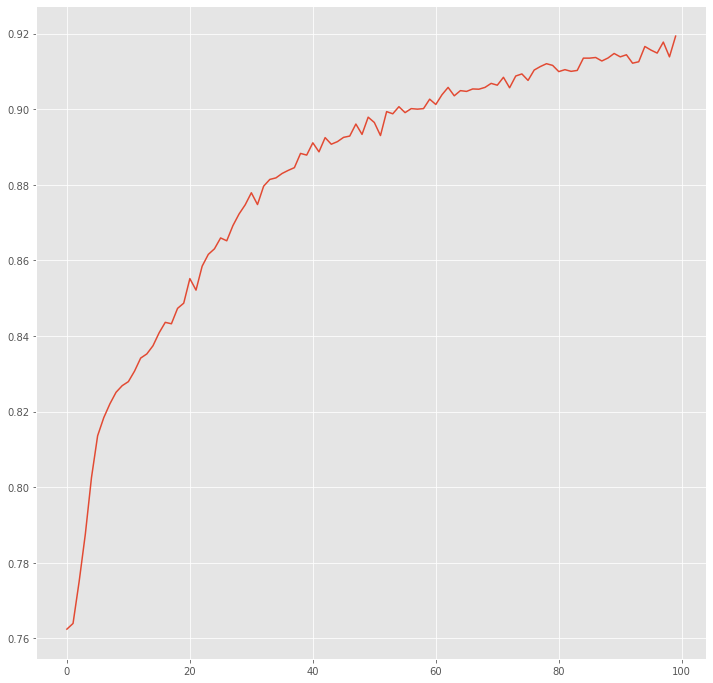

In [102]:
print('The size of training set',len(X_word_tr))
history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=100, validation_split=0.1, verbose=1)

model.save("EntityClassifierModel.h5")

hist = pd.DataFrame(history.history)
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
# plt.plot(hist["val_acc"])
plt.show()

# Evaluating our Model

In [167]:
print('The number of test documents',len(X_word_te))

#print(X_word_te[:288])

y_pred = model.predict([X_word_te, np.array(X_char_te)])

tp = 0;
N = 0;
 
print('The shape is ',y_pred.shape)

predicted_tags = []

for pre_tags in y_pred:
    for pre_tag in pre_tags:
        predicted_tags.append(idx2tag[np.argmax(pre_tag)])
    


test_tags = []
for i in range(0,len(y_te)):
    for tags in y_te[i]:
        test_tags.append(idx2tag[tags])

print("Confusion Matrix :")
print(tag2idx.keys())
print(confusion_matrix(test_tags,predicted_tags,labels = list(tag2idx.keys())))
print("Classification Report :")
print(classification_report(test_tags,predicted_tags, digits=3))

for i in range(0,len(X_word_te)):
    p = np.argmax(y_pred[i], axis=-1)

#     print("{:15}||{:5}".format("Word", "True", "Pred"))
#     print(30 * "=")
    for w, t, pred in zip(X_word_te[i], y_te[i], p):
        if w != 0:
#             print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))
            N = N + 1
            if idx2tag[t] == idx2tag[pred]:
                tp = tp + 1

print("True Positives = ",tp," Total Values = ",N, " Percentage = ", 100*tp/N)

The number of test documents 289
The shape is  (289, 50, 10)
Confusion Matrix :
dict_keys(['O', 'B-Other', 'I-Peop', 'B-Org', 'I-Loc', 'I-Org', 'B-Loc', 'B-Peop', 'I-Other', 'PAD'])
[[ 311 2049  850    0  259  734    2   76  113 1736]
 [   2   58    3    0    7   38    0    1    7   14]
 [   0   89    6    0   15   19    0    2    4  231]
 [   7   88    8    0    8    8    0    3    9   64]
 [   3   74   50    0    8   12    0    3    6   46]
 [   3  118    9    0    9    9    0    2   13   75]
 [   5  218   36    3   17   31    0    4   16   84]
 [   6  122    7    0    8   32    0    2    6  134]
 [   1   43    9    0   16   40    0    0    4   13]
 [   0    0    0    0    0    0    0    0    0 6332]]
Classification Report :
              precision    recall  f1-score   support

       B-Loc      0.000     0.000     0.000       414
       B-Org      0.000     0.000     0.000       195
     B-Other      0.020     0.446     0.039       130
      B-Peop      0.022     0.006     0.010   

In [52]:
# def model_predict(input_word_documents,input_character_documents):
#     y_pred = model.predict([np.array(input_word_documents),
#                         np.array(input_character_documents)])
#     # y_pred = model.predict([X_word_te,
#     #                         np.array(X_char_te).reshape((len(X_char_tr),
#     #                                                      max_len, max_len_char))])

#     N = 0
#     count = 0
#     for i in range(0,len(input_word_documents)):
#         p = np.argmax(y_pred[i], axis=-1)
#         print(p)
#         print("{:15}||{:5}".format("Word", "Pred"))
#         print(30 * "=")
#         with open('document'+ str(i) +'.csv', 'w', newline='') as file:
#             writer = csv.writer(file)
#             writer.writerow(["SentenceID","tokenID","Word", "Predicted","Gold Truth"])
#             token_count = 0
#             count = 0
#             for w, pred in zip(input_word_documents[i], p):
#                 if w != 0:
#                     print("{:15}: {:5}".format(idx2word[w], idx2tag[pred]))
#                     writer.writerow([i+1,token_count+1,idx2word[w], idx2tag[pred],word_tag_dict[idx2word[w]]])
#                     token_count = token_count + 1
#                     count = count + 1
#                     N = N + 1

In [27]:
# print(np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char)))
True Positives =  2195  Total Values =  2588 Epochs = 30
True Positives =  2100  Total Values =  2526 Epochs = 80
True Positives =  2242  Total Values =  2526 Epochs = 130
True Positives =  2268  Total Values =  2526 Epochs = 180
True Positives =  2293  Total Values =  2526  Percentage =  90.77593032462391 Epochs = 200

In [1]:
# word_embeddings = dict()
# with open ('vecs.lc.over100freq.txt', 'r',encoding="utf8") as f:
#     lines = f.readlines()
#     for line in lines[:500]:
#         values = line.split(' ')
#         word = values[0]
# #         print(values[1:])
#         word_embeddings[word] = [float(value) for value in values[1:-1]]
        


In [52]:
# model = tf.keras.models.load_model('BaseClassifierModel.h5')

In [16]:
# model = tf.keras.models.load_model('BaseClassifierModel.h5', custom_objects={
#     'Adam': lambda **kwargs: hvd.DistributedOptimizer(keras.optimizers.Adam(**kwargs))
# })

# Main function where we test our input data and check the predicted results given by our model

In [107]:
if __name__=='__main__':
    input_documents = []

    
    #Uncomment line 27 in model_predict before running this section


    with open('test1.txt') as f:
        doc_vector_words = []
        doc_vector_chars = []
        lines = f.readlines()
        for line in lines:
            print(word_tokenize(line))
            words = word_tokenize(line)
            word_vector = []
            temp_vector = []
            for word in words[:max_len]:
#                 word = word.lower()
                if word in word2idx.keys():
                    word_vector.append(word2idx[word])
                else:
                    word_vector.append(word2idx['UNK'])
                char_vector = []
                for c in word[:max_len_char]:
                    char_vector.append(char2idx[c])
                temp_vector.append(char_vector)

            for i in range(0, max_len - len(temp_vector)):
                temp_vector.append([0 for i in range(0,max_len_char)])

            temp_vector = pad_sequences(maxlen=max_len_char, sequences=temp_vector, value=char2idx["PAD"], padding='post', truncating='post')

            doc_vector_chars.append(temp_vector)
            doc_vector_words.append(word_vector)

    doc_vector_words = np.array(pad_sequences(maxlen=max_len, sequences=doc_vector_words, value=word2idx["PAD"], padding='post', truncating='post'))

    print(doc_vector_words.shape)
    print(np.array(doc_vector_chars).shape)
    print(words)
    model_predict(doc_vector_words,doc_vector_chars)

['Kapeel', 'brother', 'of', 'Ritwik', 'Deshpande', 'lives', 'in', 'Nagpur', 'and', 'works', 'for', 'VNIT', '.']
(1, 50)
(1, 50, 10)
['Kapeel', 'brother', 'of', 'Ritwik', 'Deshpande', 'lives', 'in', 'Nagpur', 'and', 'works', 'for', 'VNIT', '.']
[7 1 1 8 3 1 1 7 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
Word           ||Pred 
UNK            : B-Loc


IndexError: list index out of range

In [25]:
# data = pd.read_csv("document0.csv")
# with open('tain.db', 'w', newline='') as f:
#     for i in range(0,len(data['Word'])):
#         string = "EType("
#         if data['Predicted'][i] != "O":
#             string = string + str(data['SentenceID'][i]) + "," + str(data['tokenID'][i]) + "," + data['Predicted'][i][2:] + ")"
#             print(string,file=f)

In [26]:
print(words)

['Kapeel', 'brother', 'of', 'Ritwik', 'Deshpande', 'lives', 'in', 'Nagpur', 'and', 'works', 'for', 'VNIT', '.']


In [42]:
print(word2idx)

{'Paul': 2, 'Prayers': 3, 'place': 4, 'eager': 5, 'Jasray': 6, 'metereologic': 7, 'high': 8, 'Green': 9, 'submit': 10, 'NC1901223094': 11, '1784': 12, 'cold': 13, '1818': 14, 'fuel': 15, 'gas': 16, 'Swedish': 17, 'Riegle': 18, 'establish': 19, '159': 20, 'be': 21, 'coat': 22, 'claimed': 23, 'vigorous': 24, 'then-Texas': 25, 'adults': 26, 'interior': 27, 'prominence': 28, 'appropriations': 29, 'Soviets': 30, 'ratify': 31, 'nationally': 32, 'upon': 33, 'staff': 34, 'Agency': 35, 'watch': 36, 'Nonsan': 37, 'discussion': 38, 'district': 39, 'rain': 40, 'dragged': 41, 'drawings': 42, 'crewmen': 43, 'so': 44, 'Schoolbook': 45, 'proceed': 46, 'invited': 47, 'anti-communist': 48, 'Serbia': 49, 'McIntyre': 50, 'toughest': 51, 'festival': 52, 'Financial': 53, 'Tenn': 54, 'grocery': 55, 'post': 56, 'young': 57, 'adjacent': 58, 'versions': 59, 'years': 60, 'judicial': 61, 'approval': 62, 'Marko': 63, 'Healy': 64, 'Iranian': 65, 'Imelda': 66, 'truth': 67, 'French': 68, 'dance': 69, 'Liming': 70, 's

In [31]:
print(tag2idx)
print(tags)

{'B-Other': 1, 'B-Org': 2, 'I-Other': 3, 'B-Loc': 4, 'I-Org': 5, 'B-Peop': 6, 'I-Peop': 7, 'I-Loc': 8, 'O': 9, 'PAD': 0}
0


In [40]:
#import json

#print(len(documents))

#with open('sentences.txt', 'w') as file:
#    for document in documents[:1153]:
#        file.write(str(document)+"\n")

1153


# Prediction Function

In [176]:
def model_predict(input_word_documents,input_character_documents):
    model = tf.keras.models.load_model('EntityClassifierModel.h5')
    y_pred = model.predict([np.array(input_word_documents), np.array(input_character_documents)])
   
    N = 0
    count = 0

    with open('base_classifier_test.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["SentenceID","tokenID","Word", "Predicted","Gold Truth"])
        for i in range(0,288):
            p = np.argmax(y_pred[i], axis=-1)
            print(p)
            print("{:15}||{:5}".format("Word", "Pred"))
            print(30 * "=")
            token_count = 0
            count = 0
            for w, pred in zip(input_word_documents[i], p):
                if w != 0:
                    print("{:15}: {:5}".format(idx2word[w], idx2tag[pred]))
                    writer.writerow([i+1,token_count+1,idx2word[w], idx2tag[pred],document_word_tags_test[i][idx2word[w]]])
                    token_count = token_count + 1
                    count = count + 1
                    N = N + 1

# Testing Using CoNLL Dataset

In [177]:
def get_words(document):
    test_words = []
    for tup in document:
        test_words.append(tup[0])

    return test_words

if __name__=='__main__':

    model_predict(X_word_te,X_char_te)



289
289
[1 2 1 1 1 1 1 1 1 1 4 6 1 7 1 8 1 1 1 1 1 1 1 8 3 3 1 1 1 1 1 1 1 9 9 1 1
 1 1 1 1 1 1 7 1 1 1 1 1 1]
Word           ||Pred 
On             : O    
April          : B-Other
14             : O    
,              : O    
while          : O    
attending      : O    
a              : O    
play           : O    
at             : O    
the            : O    
Ford           : B-Org
Theatre        : I-Org
in             : O    
Washington     : B-Loc
,              : O    
Lincoln        : B-Peop
was            : O    
shot           : O    
in             : O    
the            : O    
head           : O    
by             : O    
actor          : O    
John           : B-Peop
Wilkes         : I-Peop
Booth          : I-Peop
,              : O    
who            : O    
cried          : O    
out            : O    
`              : O    
`              : O    
Sic            : O    
Semper         : I-Other
Tyranus        : I-Other
'              : O    
'              : O    
(    

interim        : O    
agreement      : O    
that           : O    
allowed        : O    
resumption     : O    
of             : O    
sales          : O    
of             : O    
about          : O    
15             : B-Other
percent        : I-Other
of             : O    
the            : O    
$100           : B-Other
million        : I-Other
in             : O    
U.S.           : B-Loc
beef           : O    
exports        : O    
to             : O    
Europe         : B-Loc
.              : O    
[1 8 3 1 1 1 1 1 4 6 6 1 1 1 7 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
Word           ||Pred 
The            : O    
Australian     : B-Peop
Government     : I-Peop
has            : O    
considered     : O    
inviting       : O    
a              : O    
senior         : O    
North          : B-Org
Korean         : I-Org
Government     : I-Org
official       : O    
to             : O    
visit          : O    
Australia      : B-Loc
later        

agricultural   : O    
official       : O    
,              : O    
at             : O    
the            : O    
EU             : B-Org
headquarters   : O    
in             : O    
Brussels       : B-Loc
.              : O    
[1 1 1 1 1 1 7 5 1 7 1 1 1 1 7 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
Word           ||Pred 
About          : O    
1              : O    
,              : O    
000            : O    
soldiers       : O    
from           : O    
Fort           : B-Loc
Lewis          : I-Loc
,              : O    
Wash.          : B-Loc
,              : O    
were           : O    
summoned       : O    
to             : O    
Oregon         : B-Loc
for            : O    
on-the-job     : O    
training       : O    
before         : O    
being          : O    
thrown         : O    
on             : O    
to             : O    
the            : O    
front          : O    
lines          : O    
.              : O    
[7 1 7 1 1 1 1 1 1 1 1 

adviser        : O    
to             : O    
PLO            : B-Org
Chairman       : I-Org
Yasir          : I-Org
'Arafat        : I-Org
by             : O    
Sa             : B-Loc
'id            : O    
Mu             : I-Org
'addi          : O    
in             : O    
Cairo          : B-Loc
on             : O    
18             : B-Other
May            : I-Other
from           : O    
the            : O    
"              : O    
With           : O    
the            : O    
Midday         : O    
Events         : I-Org
"              : O    
program        : O    
--             : O    
recorded       : O    
)              : O    
(              : O    
Excerpt        : O    
)              : O    
(              : O    
passage        : O    
omitted        : O    
)              : O    
(              : O    
Mu             : O    
'addi          : O    
)              : O    
One            : O    
last           : O    
question       : O    
,              : O    
Dr.    

In [171]:
print(document_word_tags_test[287])

{'In': 'O', 'Washington': 'B-Loc', 'state': 'O', ',': 'O', 'an': 'O', '850-acre': 'O', 'fire': 'O', 'burning': 'O', 'in': 'O', 'the': 'O', 'Cascade': 'B-Loc', 'range': 'O', 'near': 'O', 'Canadian': 'O', 'border': 'O', 'was': 'O', '84': 'B-Other', 'percent': 'I-Other', 'contained': 'O', 'Tuesday': 'O', 'said': 'O', 'Greg': 'B-Peop', 'Thayer': 'I-Peop', 'of': 'O', 'U.S.': 'B-Org', 'Forest': 'I-Org', 'Service': 'I-Org', '.': 'O'}


In [80]:
# print(tag2idx)